Whole-cell currents in 5-HT neurons recorded at 29-30 C.

In [1]:
from common import colors, sbarlw, insetlw, savefig

In [2]:
import os
os.chdir(os.path.join('..', '..'))
print(os.getcwd())

/home/efharkin/projects/raphegif/raphegif


In [3]:
from __future__ import division, print_function

import pickle
import warnings

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import seaborn as sns
from scipy import stats
from scipy.signal import find_peaks
import pandas as pd

from ezephys import pltools
from ezephys.rectools import ABFLoader
from grr.cell_class import (
    subtract_baseline,
    subtract_leak,
)
from grr.CurveFit import fit_decay_curve, fit_gating_curve, plot_linear_fit
from grr.Tools import dashedBorder, timeToIndex

In [4]:
IMG_PATH = os.getenv('IMG_PATH')
DATA_PATH = os.getenv('DATA_PATH')
NOTEBOOK_PATH = os.path.join('figs', 'scripts')

plt.style.use(os.path.join(NOTEBOOK_PATH, 'publication_figure_style.dms'))

## Load recordings

In [5]:
rec_index = pd.read_csv(os.path.join(DATA_PATH, 'raw', '5HT', 'heated_gating', 'index.csv'))
rec_index

,cell_id,membrane_resistance_megaohm,membrane_capacitance_picofarad,access_resistance_megaohm,holding_current_picoamp,filename,comment,ttx_micromolar,nicl2_millimolar,heteropodatoxin2_nanomolar,ammtx3_micromolar,command_scaling,include
0,DRN1065,1000,50,40,NaN,22224042.abf,Unclamped action potentials? 10mV step increme...,0.5,0,0,0,1,False
1,DRN1066,600,80,15,NaN,22224044.abf,"10mV step increments, voltage offset 20 mV",1.0,0,0,0,1,False
2,DRN1067,1000,50,22,NaN,22224046.abf,10mV step increments,1.0,0,0,0,1,True
3,DRN1067,1000,50,22,NaN,22224047.abf,10mV step increments,1.0,10,0,0,1,True
4,DRN1116,500,70,19,NaN,22407000.abf,5mV step increments,1.0,0,0,0,20,True
5,DRN1118,300,60,10,NaN,22407001.abf,5mV step increments,1.0,0,0,0,20,True
6,DRN1119,500,40,14,NaN,22407002.abf,5mV step increments,1.0,0,0,0,20,True
7,DRN1119,500,40,14,NaN,22407004.abf,5mV step increments,1.0,0,500,0,20,True
8,DRN1119,500,40,14,NaN,22407006.abf,5mV step increments,1.0,0,500,1,20,True
9,DRN1120,300,30,5,NaN,22407008.abf,5mV step increments,1.0,0,0,0,20,True


In [6]:
ctrl_rec_index = rec_index.query(
    'access_resistance_megaohm <= 20 '
    'and nicl2_millimolar == 0 '
    'and heteropodatoxin2_nanomolar == 0 '
    'and ammtx3_micromolar == 0 '
    'and include'
)

CURRENT_CHANNEL, VOLTAGE_CHANNEL = 0, 1

l = ABFLoader()
ctrl_recs = []
for _, row in ctrl_rec_index.iterrows():
    rec = l.load(
        os.path.join(DATA_PATH, 'raw', '5HT', 'heated_gating', row['filename'])
    )[0]
    rec[VOLTAGE_CHANNEL, ...] /= row['command_scaling']
    ctrl_recs.append(rec)

del l, rec
ctrl_rec_index

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


,cell_id,membrane_resistance_megaohm,membrane_capacitance_picofarad,access_resistance_megaohm,holding_current_picoamp,filename,comment,ttx_micromolar,nicl2_millimolar,heteropodatoxin2_nanomolar,ammtx3_micromolar,command_scaling,include
4,DRN1116,500,70,19,NaN,22407000.abf,5mV step increments,1.0,0,0,0,20,True
5,DRN1118,300,60,10,NaN,22407001.abf,5mV step increments,1.0,0,0,0,20,True
6,DRN1119,500,40,14,NaN,22407002.abf,5mV step increments,1.0,0,0,0,20,True
9,DRN1120,300,30,5,NaN,22407008.abf,5mV step increments,1.0,0,0,0,20,True
11,DRN1121,500,55,12,NaN,22407011.abf,5mV step increments,1.0,0,0,0,20,True


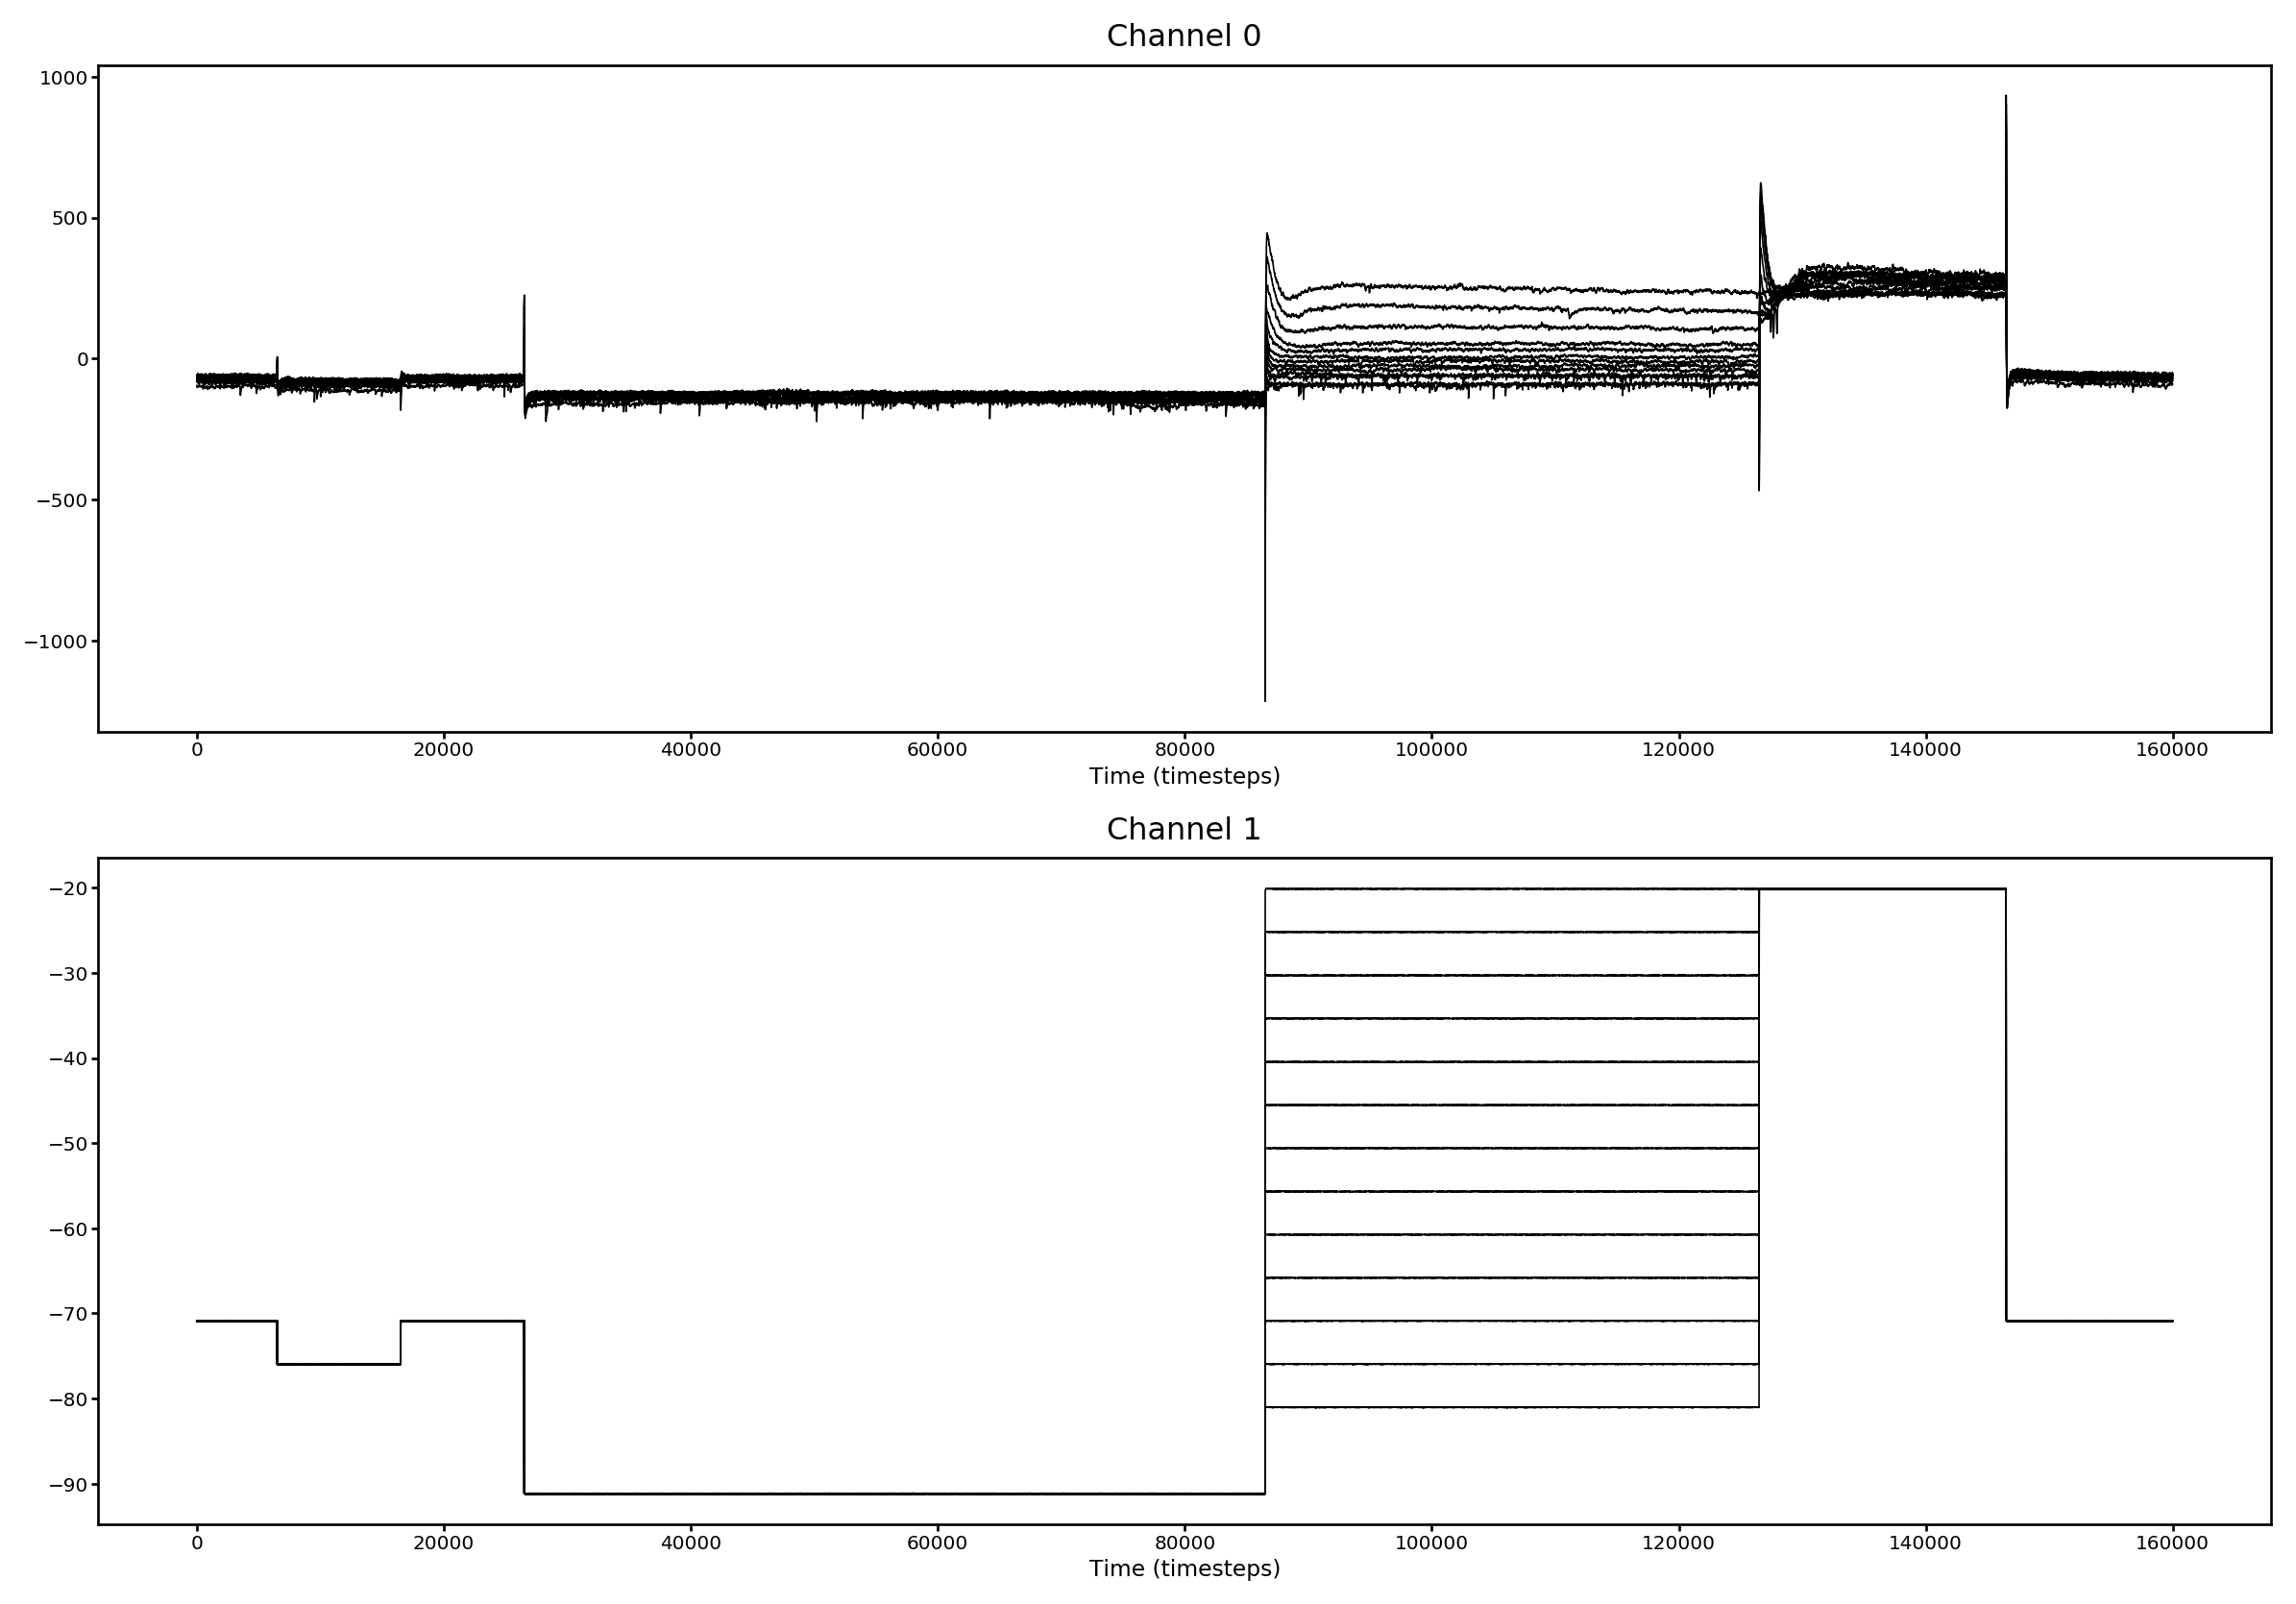

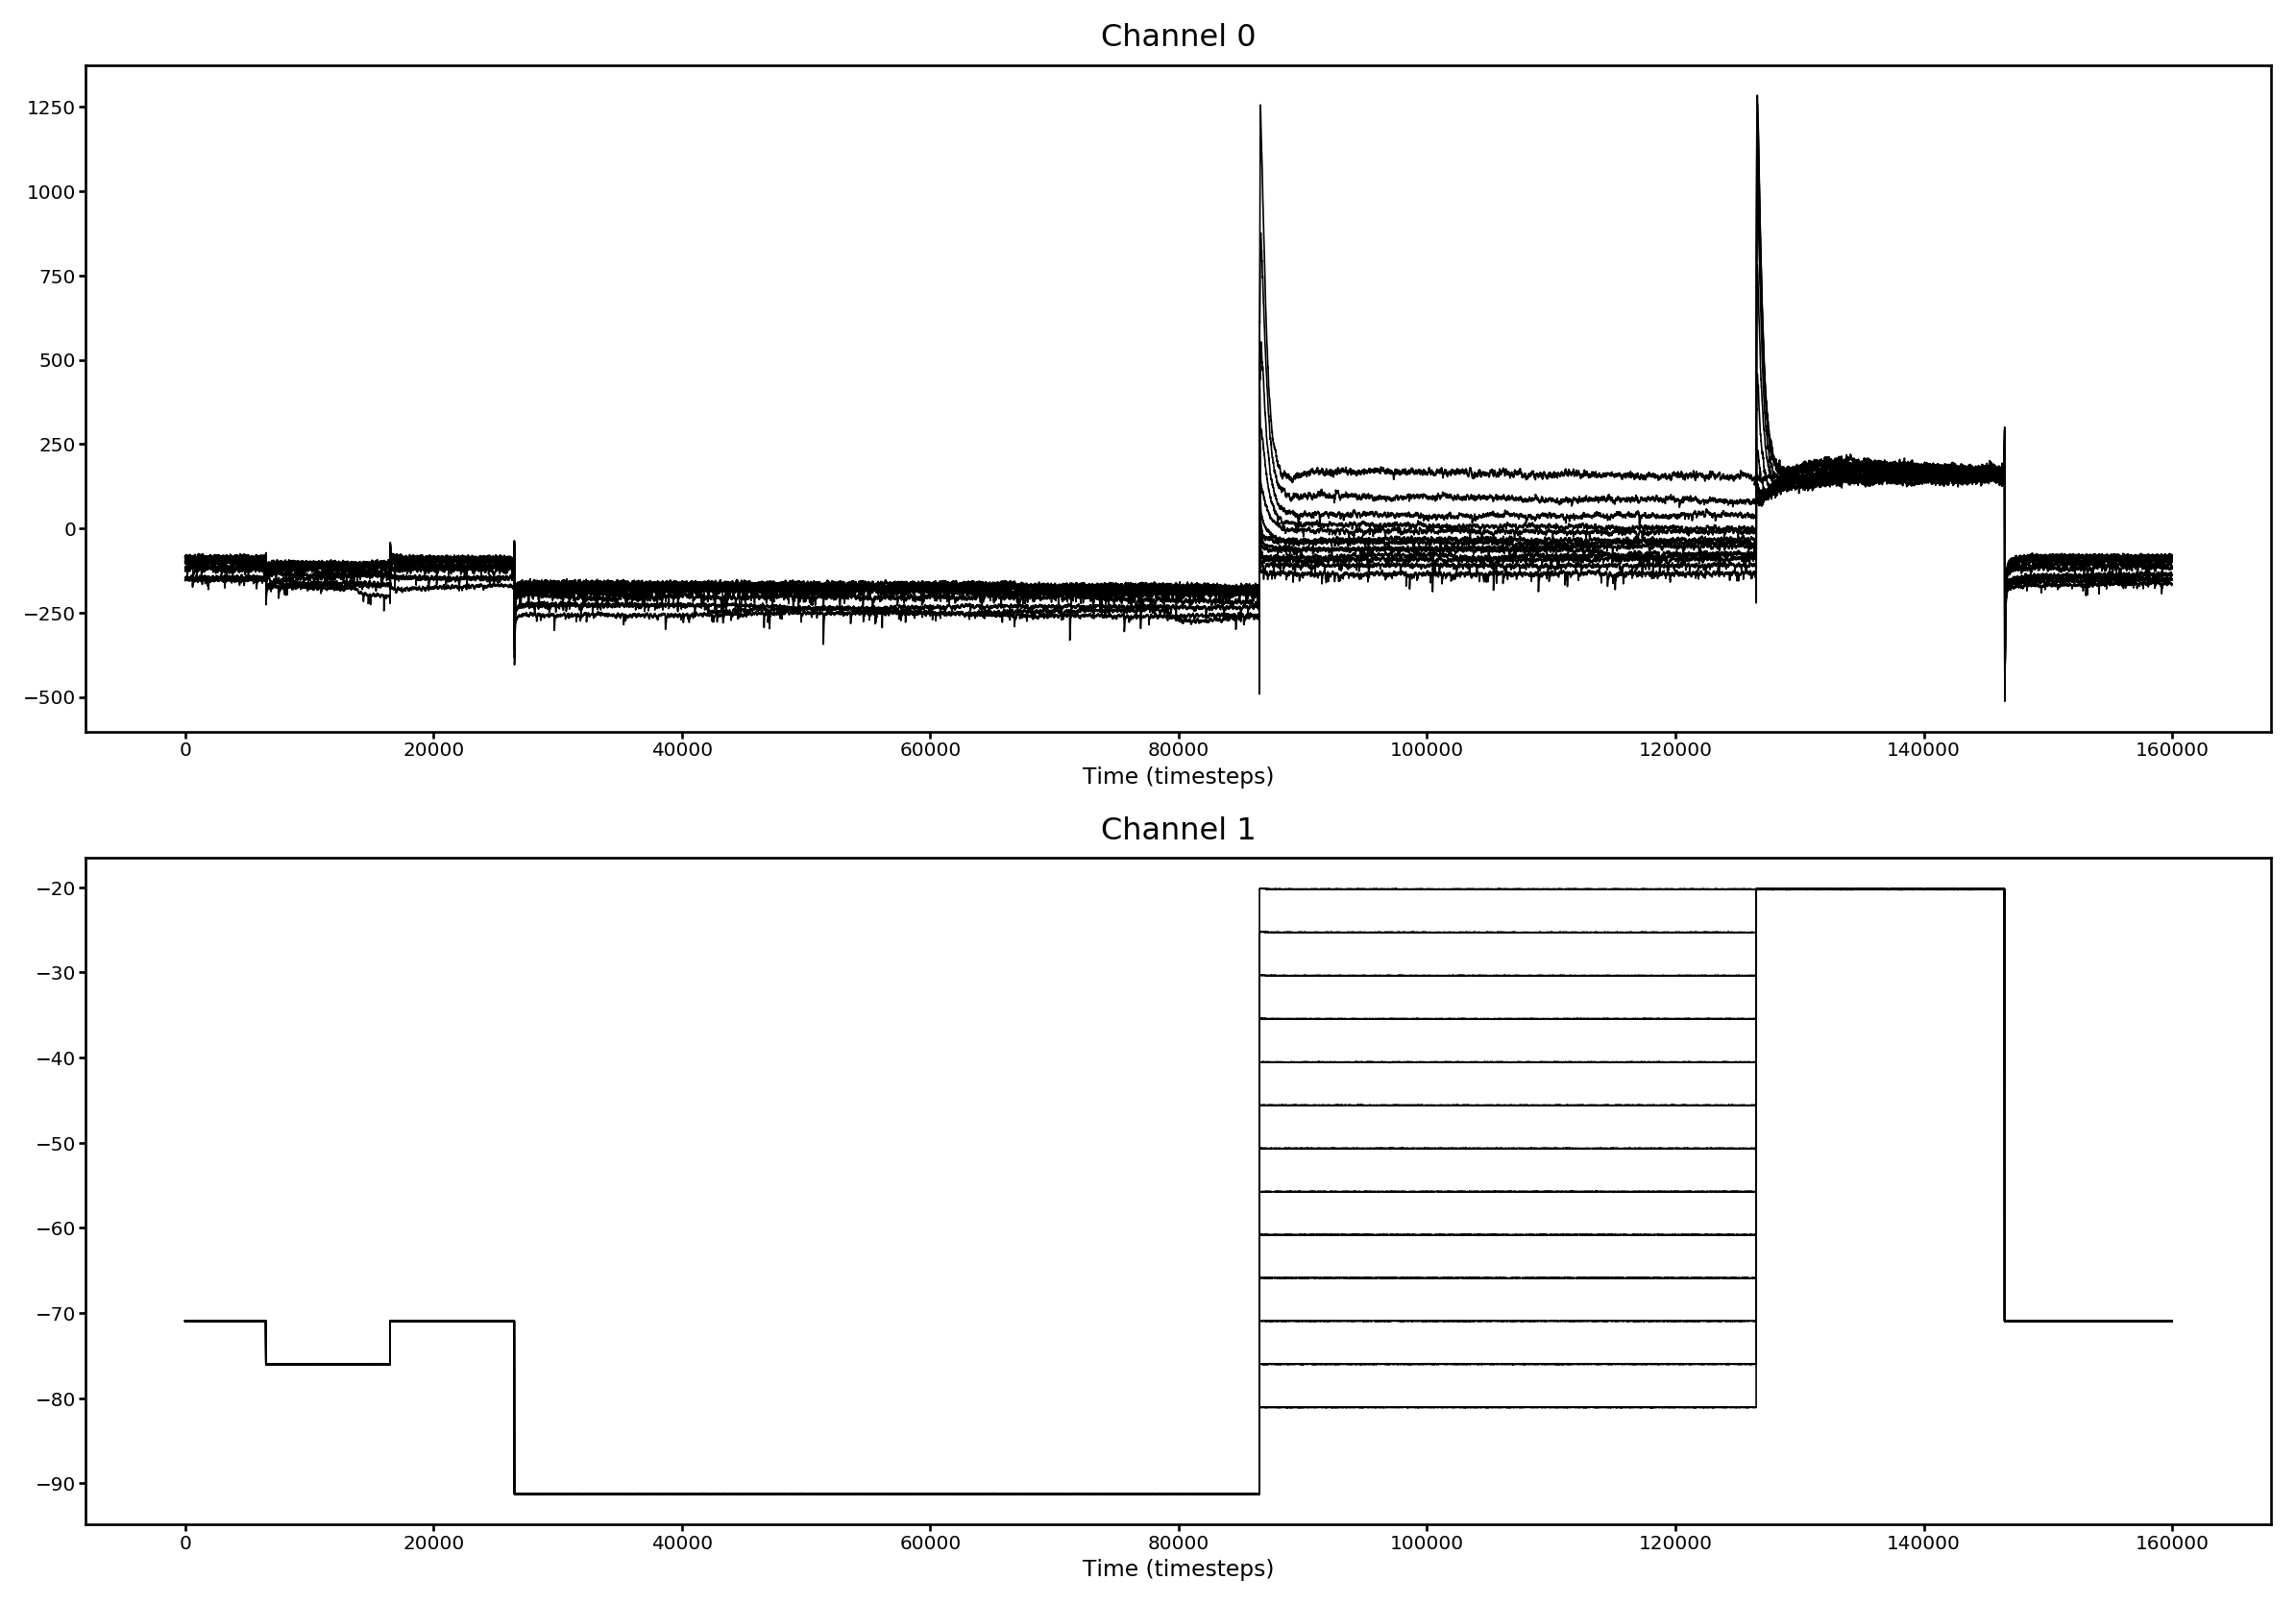

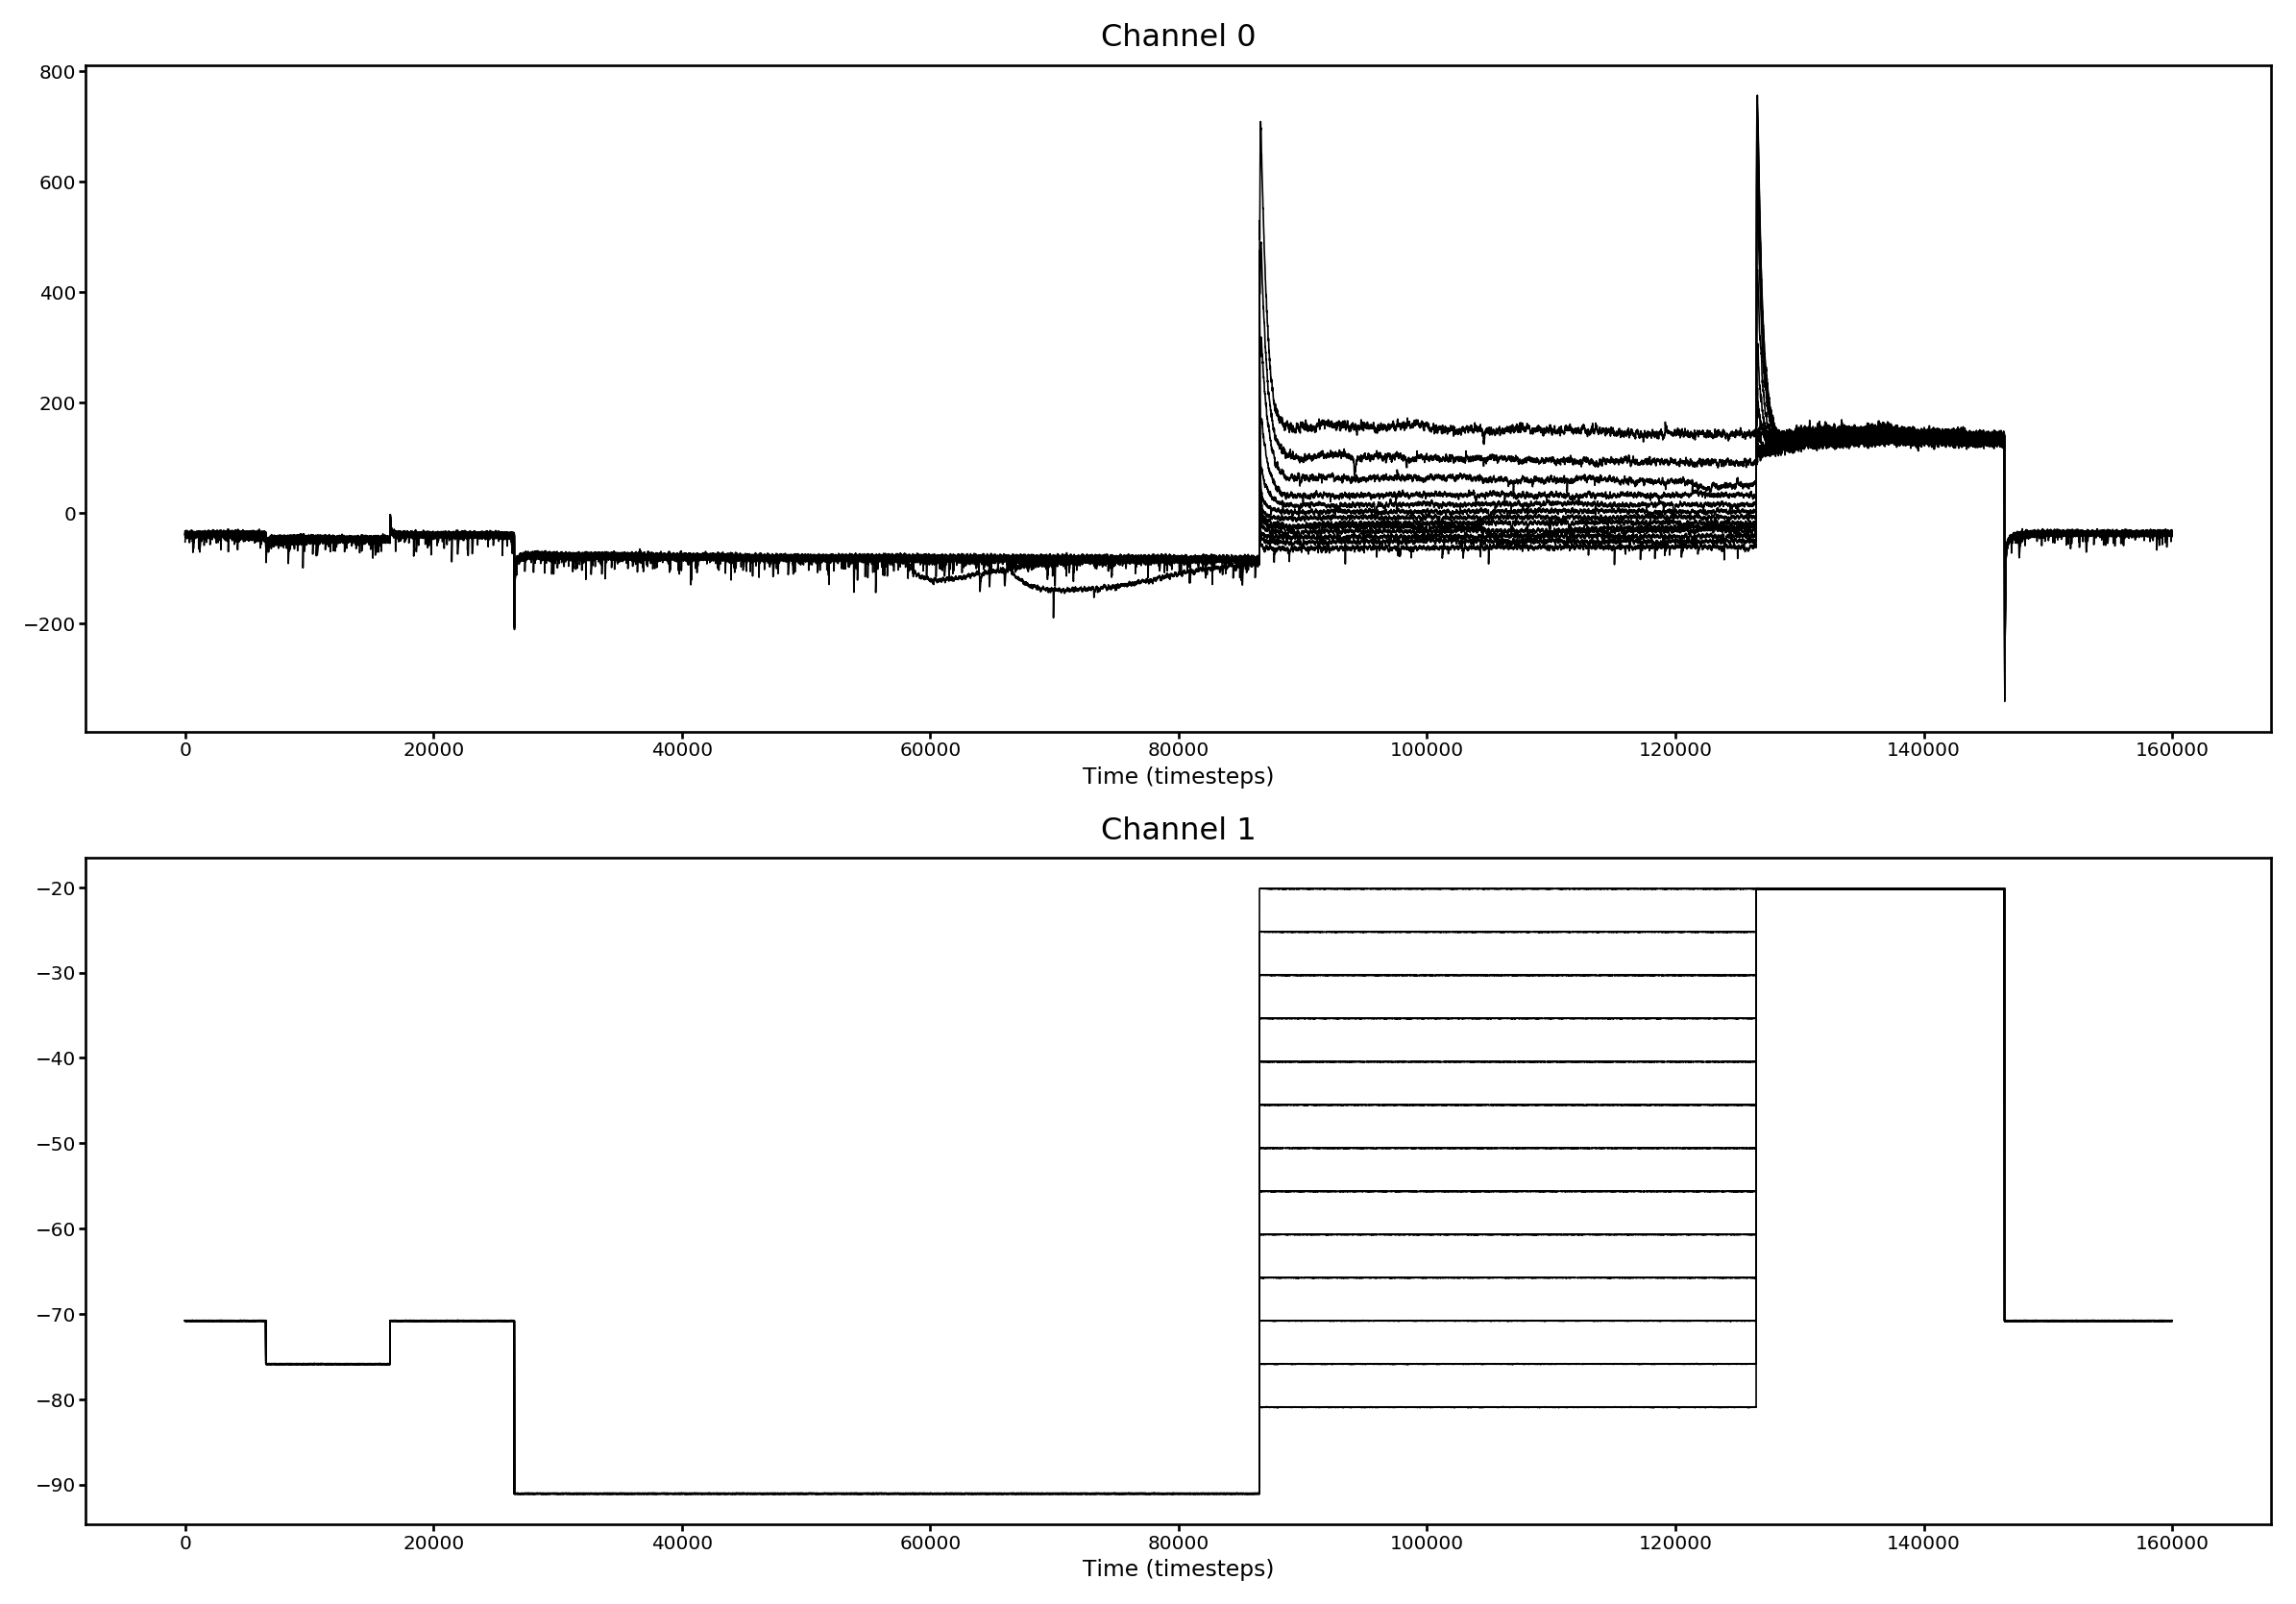

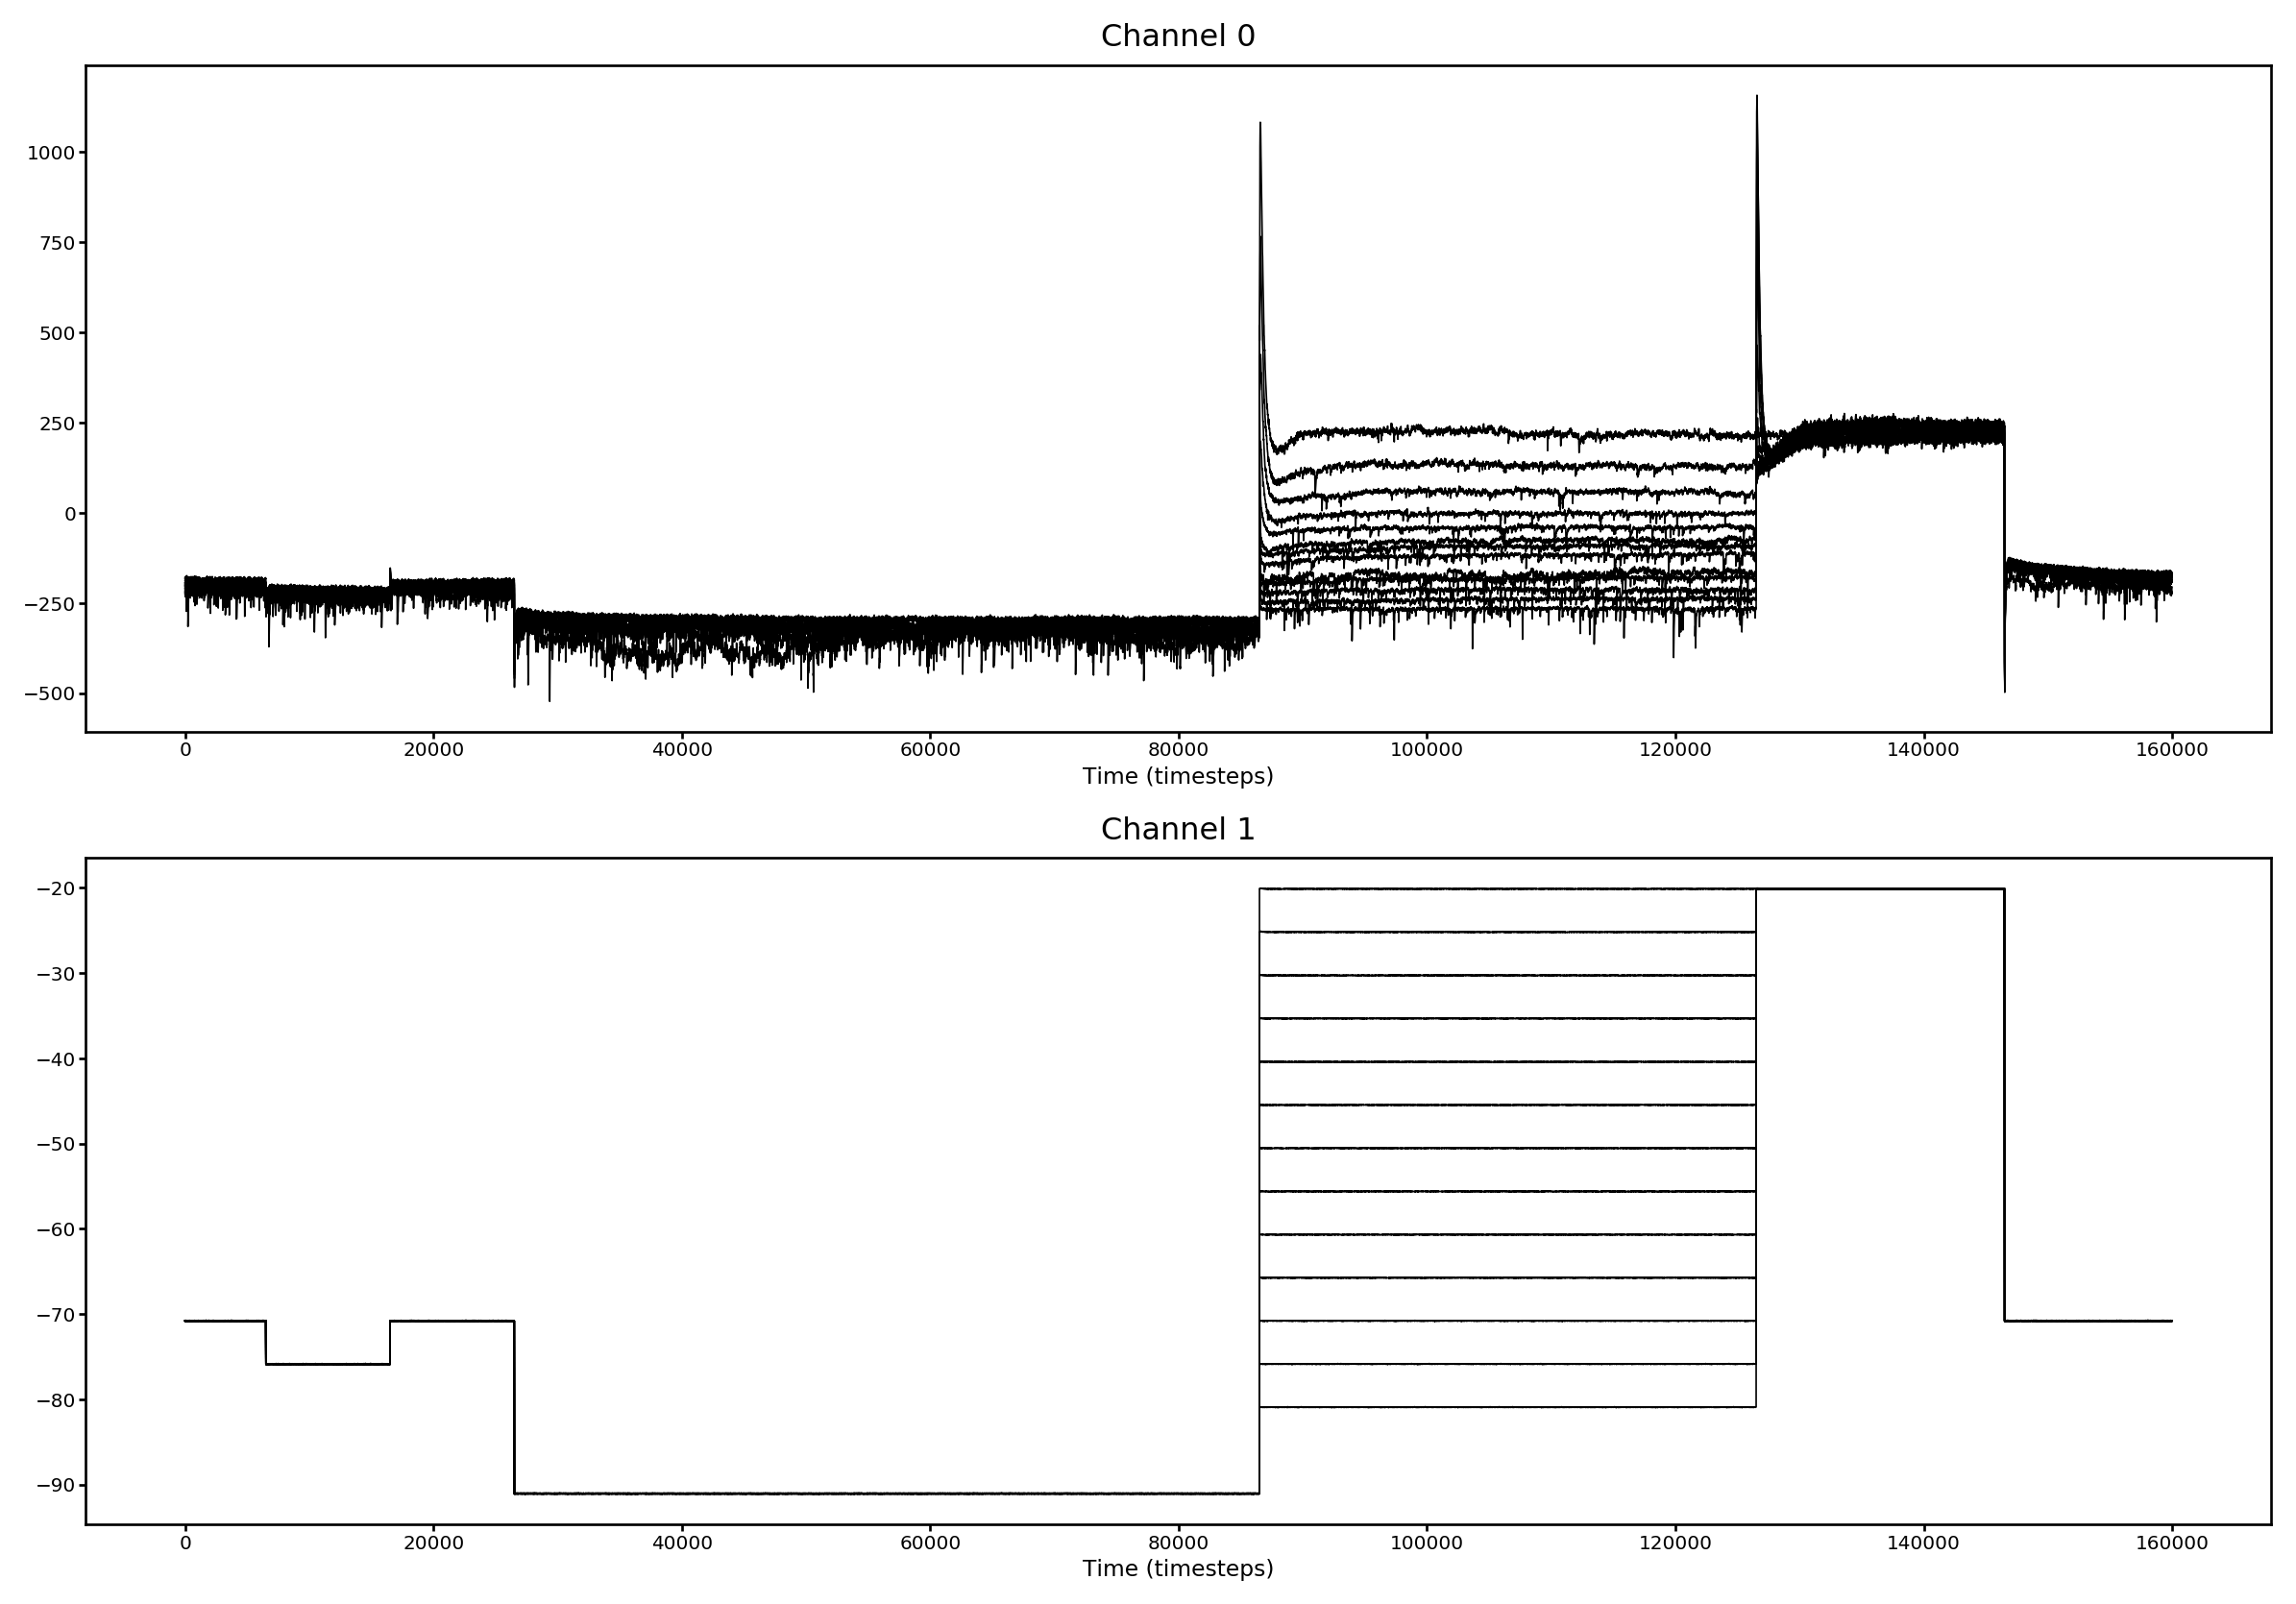

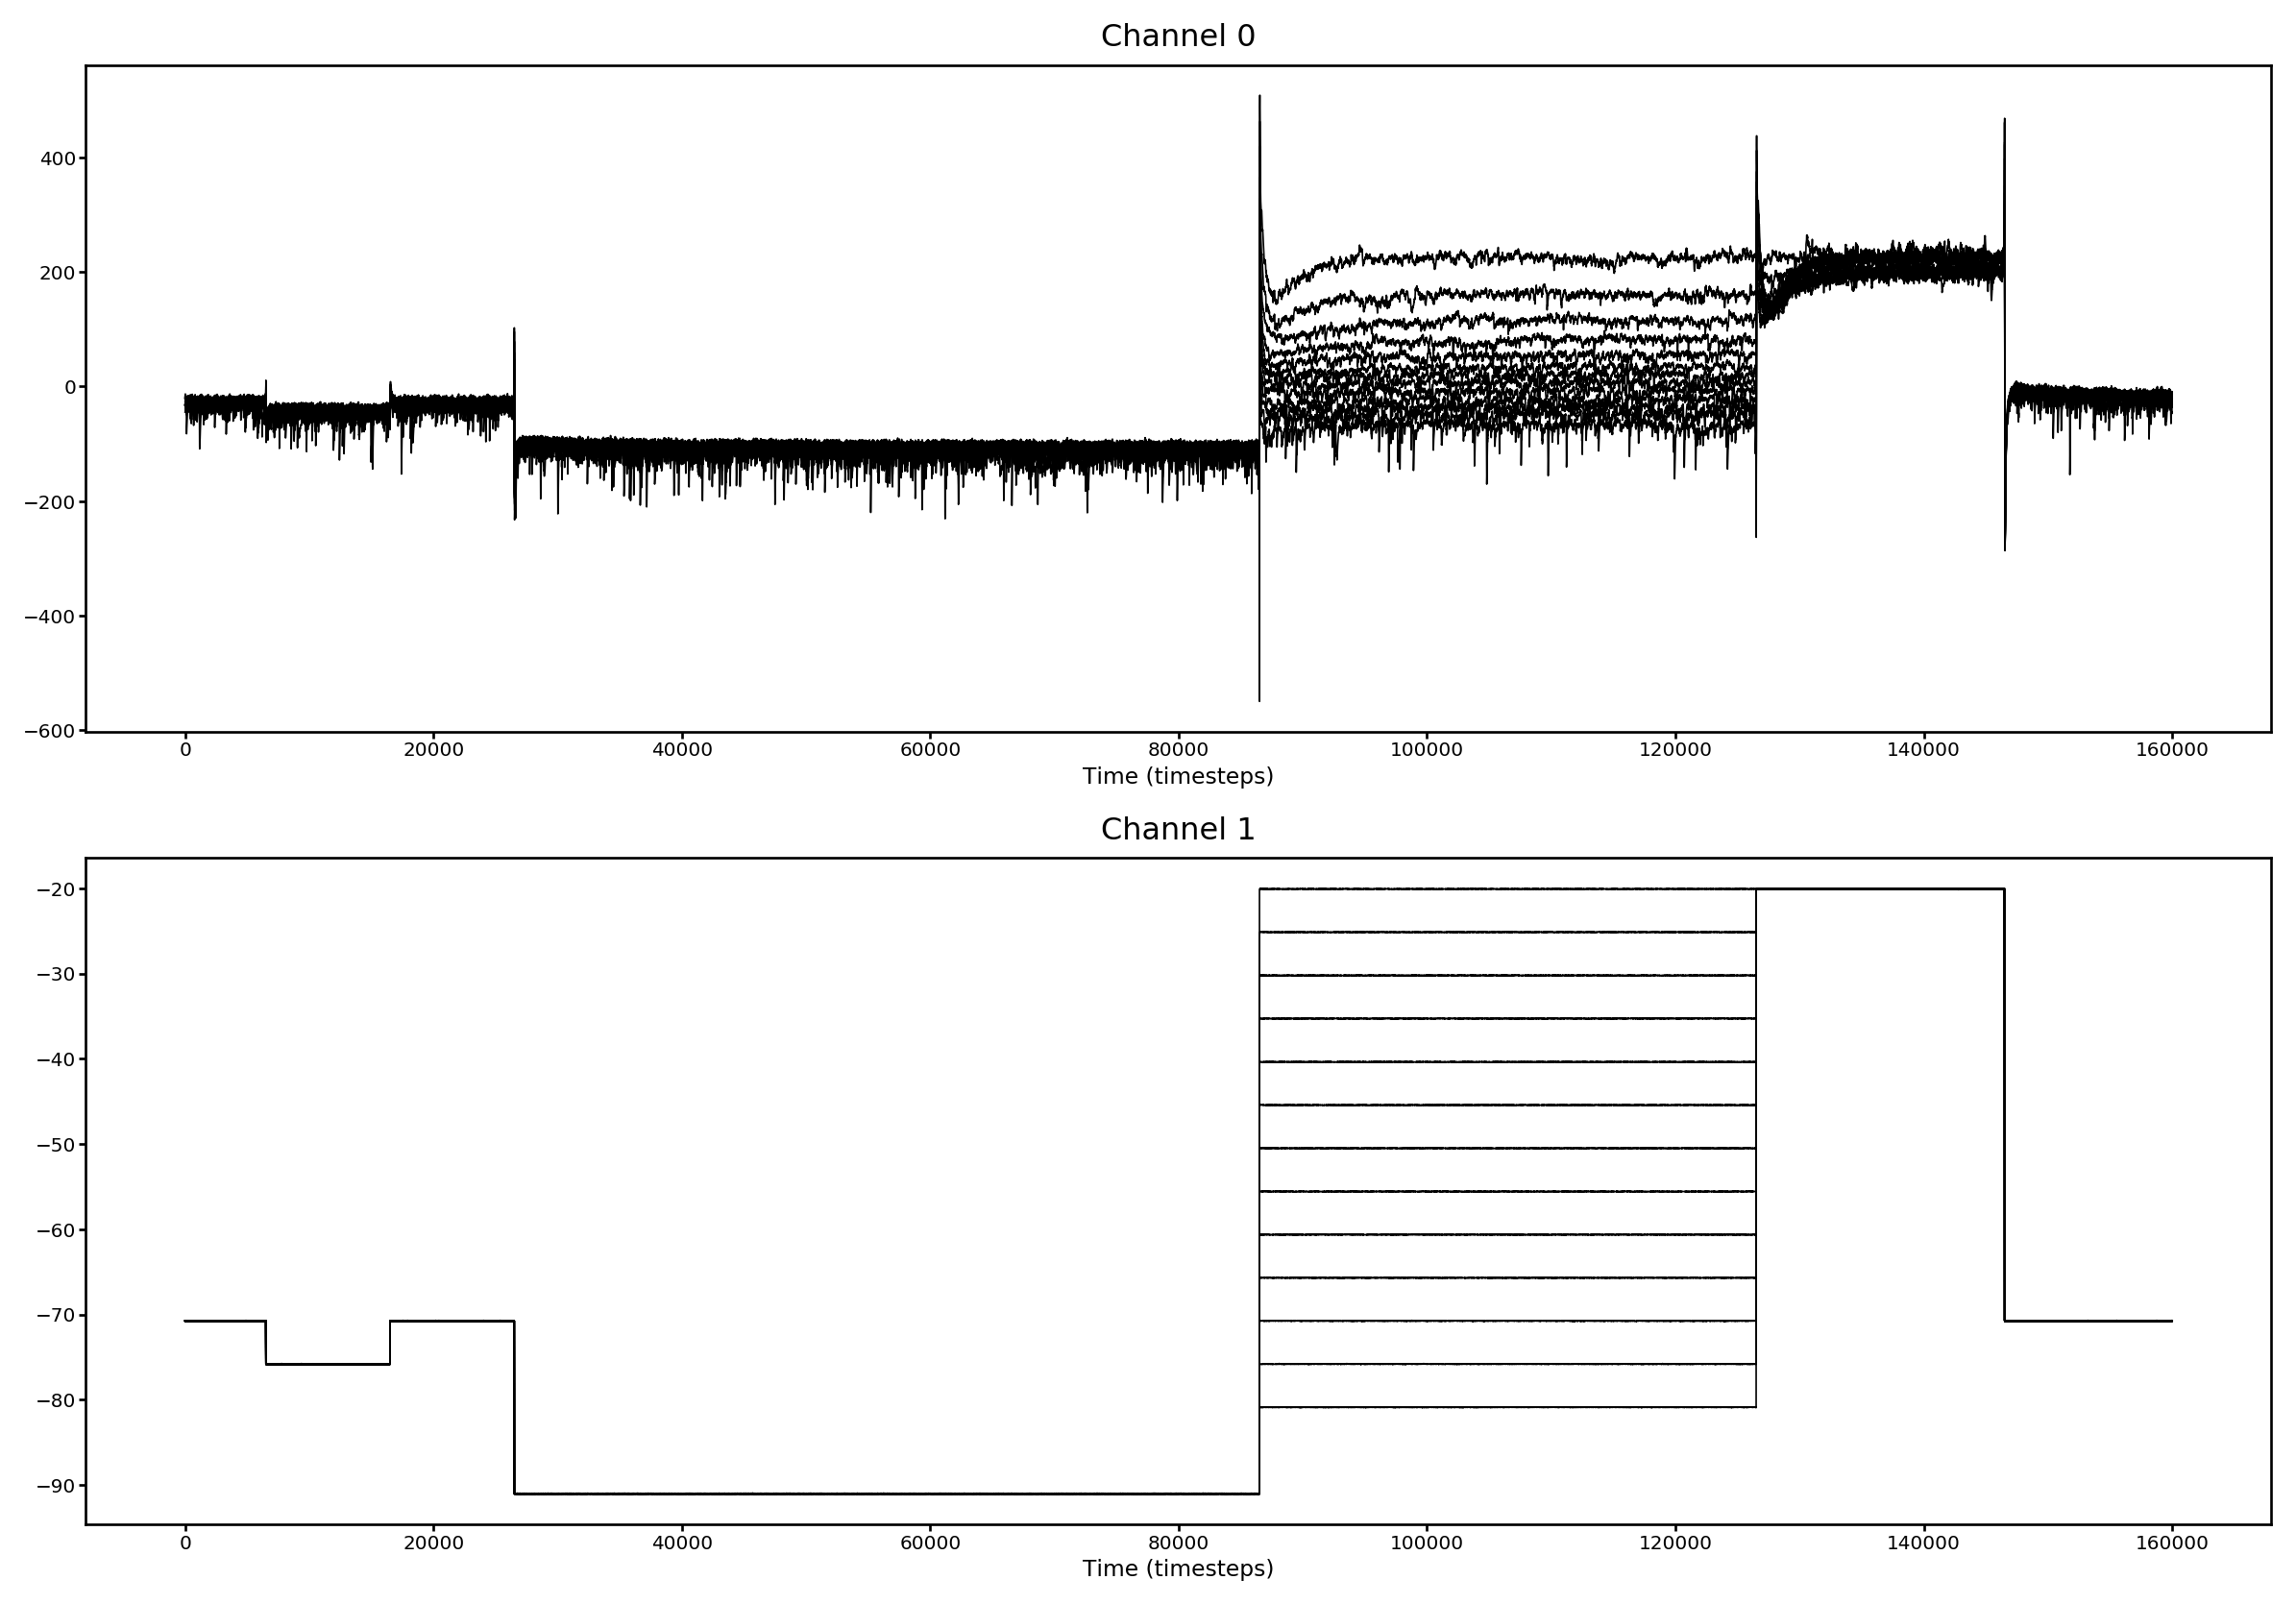

In [7]:
for r in ctrl_recs:
    r.plot()

In [8]:
print(
    '{} cells with access resistance <= 20 MOhm '
    '(Ra = {:.1f} MOhm +/- {:.1f} MOhm, mean +/- SD)'.format(
        ctrl_rec_index.shape[0],
        ctrl_rec_index['access_resistance_megaohm'].mean(),
        ctrl_rec_index['access_resistance_megaohm'].std()
    )
)

5 cells with access resistance <= 20 MOhm (Ra = 12.0 MOhm +/- 5.1 MOhm, mean +/- SD)


In [9]:
CURRENT_CHANNEL, VOLTAGE_CHANNEL = 0, 1

print('Command voltages in mV for each sweep')
print('Baseline: {}'.format(ctrl_recs[0][VOLTAGE_CHANNEL, 0, :]))
print('De-inactivating pre-pulse: {}'.format(ctrl_recs[0][VOLTAGE_CHANNEL, 60000, :]))
print('Activation step: {}'.format(ctrl_recs[0][VOLTAGE_CHANNEL, 100000, :]))

Command voltages in mV for each sweep
Baseline: [-70.8618103  -70.89232788 -70.89232788 -70.8618103  -70.8618103
 -70.8618103  -70.89232788 -70.89232788 -70.89232788 -70.92284546
 -70.92284546 -70.8618103  -70.89232788]
De-inactivating pre-pulse: [-91.15599976 -91.18651733 -91.15599976 -91.18651733 -91.15599976
 -91.18651733 -91.15599976 -91.15599976 -91.21703491 -91.15599976
 -91.18651733 -91.18651733 -91.18651733]
Activation step: [-81.0546814  -75.92772827 -70.89232788 -65.85692749 -60.72998047
 -55.69458008 -50.59814148 -45.50170593 -40.43578796 -35.36987
 -30.30395508 -25.17700043 -20.14160004]


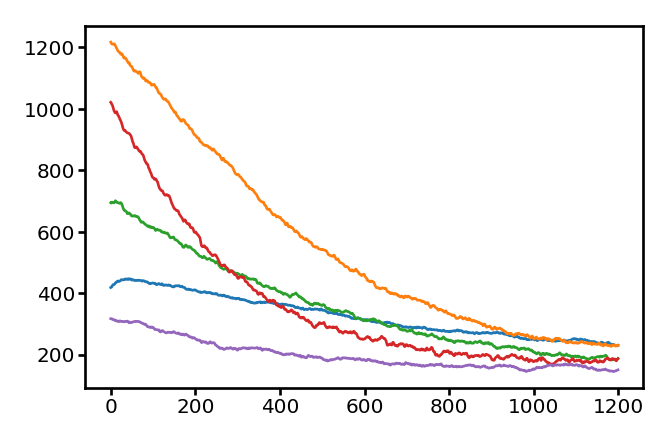

In [10]:
for r in ctrl_recs:
    plt.plot(r[CURRENT_CHANNEL, 86620:87820, -1])

## Subtract baseline/leak

In [11]:
def preprocess_recording(recording):
    """Dirty helper function for baseline and leak current subtraction."""
    baseline_slice = slice(2500, 5000)
    test_pulse_slice = slice(10000, 15000)

    baseline_subtracted = subtract_baseline(
        recording, baseline_slice, CURRENT_CHANNEL
    )
    fully_processed = subtract_leak(
        baseline_subtracted,
        baseline_slice,
        test_pulse_slice,
        VOLTAGE_CHANNEL,
        CURRENT_CHANNEL,
    )
    return fully_processed

ctrl_recs = [preprocess_recording(r) for r in ctrl_recs]

## Fit decay

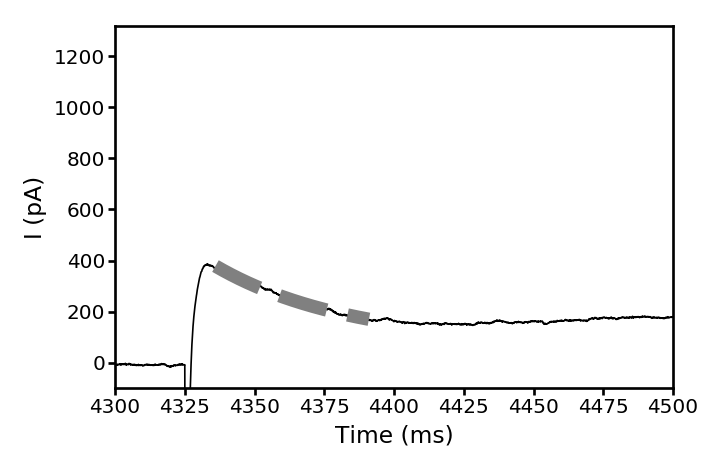

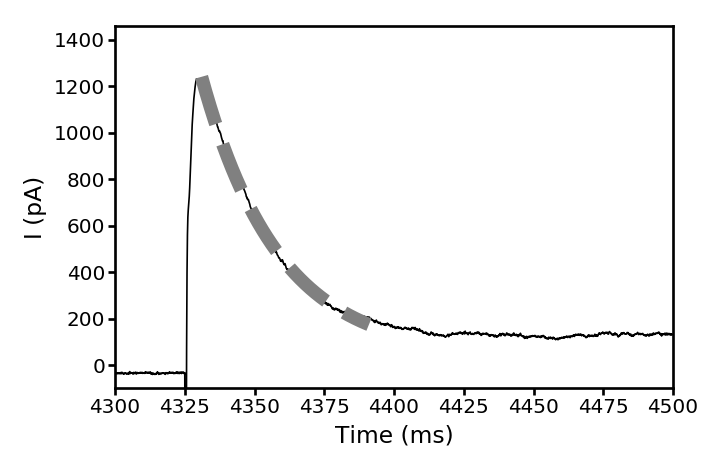

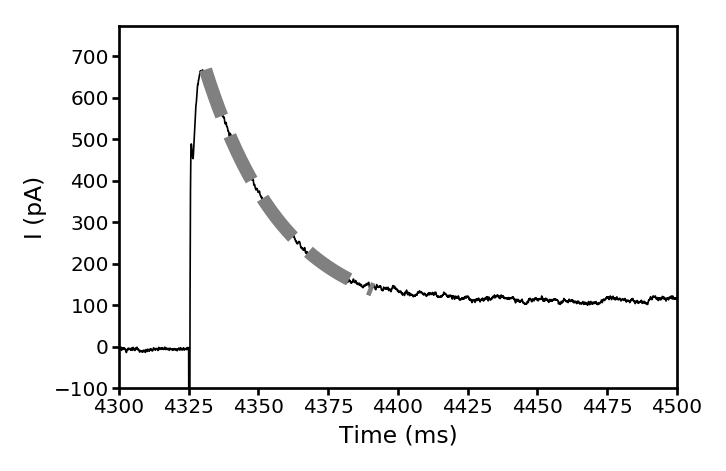

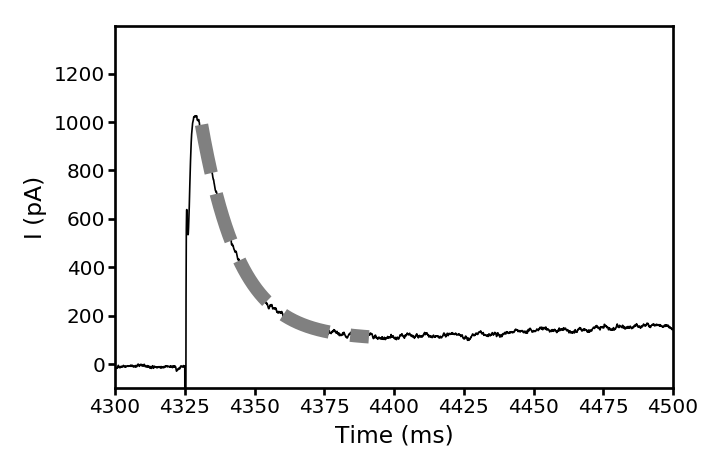

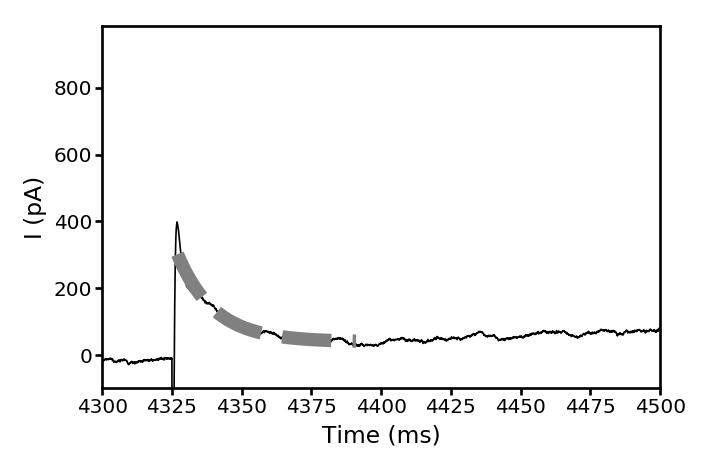

IA inactivation tau 26.1 +/- 12.8 (mean +/- SD)


In [12]:
STEP_AMPLITUDE = 50  # 70mV (-70 to -20)

IA_inactivation = {
    'traces': [],
    'fitted_data': [],
    'fitted_curves': [],
    'range_fitted': [],
    'inactivation_taus': [],
    'peak_latencies': [],
    'peak_amplitudes': [],
    'steady_state_amplitudes': [],
    'peak_exists': [],
}

peak_fit_params = {
    'stimulus_start_time': 4325.0,
    'steady_state_time': 6000.0,
    'peak_slice': slice(86520, 88000),
    'decay_slice': [
        slice(86720, 87820),
        slice(86620, 87820),
        slice(86620, 87820),
        slice(86620, 87820),
        slice(86540, 87820),
    ],
}

for i, rec in enumerate(ctrl_recs):
    # Determine whether there is a peak using same method as for GABA.
    peak_inds = find_peaks(
        rec[0, peak_fit_params['peak_slice'], -1],
        distance=500,
        prominence=50.0,
        width=100,
    )[0]
    IA_inactivation['peak_exists'].append(len(peak_inds) > 0)
    if len(peak_inds) > 1:
        warnings.warn(
            '{} peaks detected for recording {}.'.format(len(peak_inds), i)
        )

    # Find peak latency
    IA_inactivation['peak_latencies'].append(
        np.argmax(rec[0, peak_fit_params['peak_slice'], -1]) * rec.dt
        + peak_fit_params['peak_slice'].start * rec.dt
        - peak_fit_params['stimulus_start_time']
    )

    # Get peak amplitude.
    IA_inactivation['peak_amplitudes'].append(
        rec[
            0,
            np.argmax(rec[0, peak_fit_params['peak_slice'], -1])
            + peak_fit_params['peak_slice'].start,
            -1,
        ]
    )

    # Get steady-state amplitude
    IA_inactivation['steady_state_amplitudes'].append(
        rec[0, timeToIndex(peak_fit_params['steady_state_time'], rec.dt)[0], -1]
    )

    # Fit decay
    IA_inactivation['range_fitted'].append(
        [
            peak_fit_params['decay_slice'][i].start * rec.dt,
            peak_fit_params['decay_slice'][i].stop * rec.dt,
        ]
    )

    t_vec = np.arange(0, rec.shape[1], rec.dt)[: rec.shape[1]]
    fitted_tmp = rec[0, peak_fit_params['decay_slice'][i], -1]
    IA_inactivation['fitted_data'].append(
        np.array([fitted_tmp, t_vec[peak_fit_params['decay_slice'][i]]])
    )

    IA_inactivation['traces'].append(
        np.array([rec[0, :, -1], rec[1, :, -1], t_vec])
    )

    p_tmp, fitted_tmp = fit_decay_curve(
        fitted_tmp,
        [fitted_tmp[0] - fitted_tmp[-1], fitted_tmp[-1], 20],
        dt=rec.dt,
    )

    IA_inactivation['inactivation_taus'].append(p_tmp[2])
    IA_inactivation['fitted_curves'].append(
        np.array(
            [
                fitted_tmp[0, :],
                np.linspace(
                    peak_fit_params['decay_slice'][i].start * rec.dt,
                    peak_fit_params['decay_slice'][i].stop * rec.dt,
                    len(fitted_tmp[0, :]),
                ),
            ]
        )
    )

    # Diagnostic plot of decay fit.
    plt.figure()
    plt.plot(t_vec, rec[0, :, -1], 'k-', lw=0.5)
    plt.plot(
        np.linspace(
            peak_fit_params['decay_slice'][i].start * rec.dt,
            peak_fit_params['decay_slice'][i].stop * rec.dt,
            len(fitted_tmp[0, :]),
        ),
        fitted_tmp[0, :],
        '--',
        color='gray',
        lw=4,
    )
    plt.ylabel('I (pA)')
    plt.xlabel('Time (ms)')
    plt.xlim(4300, 4500)
    plt.ylim(-100, plt.ylim()[1])
    plt.show()


IA_inactivation = {
    k: (
        np.array(v) 
        if k not in {'fitted_data', 'fitted_curves'}
        else v
    )
    for k, v in IA_inactivation.items()
}
print(
    'IA inactivation tau {:.1f} +/- {:.1f} (mean +/- SD)'.format(
        IA_inactivation['inactivation_taus'].mean(),
        IA_inactivation['inactivation_taus'].std(),
    )
)

#with open(PROCESSED_PATH + 'inactivation_fits.dat', 'wb') as f:
#    pickle.dump(IA_inactivation, f)

In [13]:
IA_inactivation.keys()

['traces',
 'fitted_data',
 'steady_state_amplitudes',
 'inactivation_taus',
 'peak_amplitudes',
 'peak_exists',
 'fitted_curves',
 'peak_latencies',
 'range_fitted']

In [14]:
for dataset in [
    'peak_amplitudes',
    'peak_latencies',
    'steady_state_amplitudes',
    'inactivation_taus',
]:
    print(
        '{:>25} {:>10.3} +/- {:>5.3}'.format(
            dataset,
            np.mean(IA_inactivation[dataset]),
            stats.sem(IA_inactivation[dataset]),
        )
    )

          peak_amplitudes   7.42e+02 +/- 1.69e+02
           peak_latencies       4.65 +/-   1.0
  steady_state_amplitudes   1.34e+02 +/-  14.7
        inactivation_taus       26.1 +/-   6.4


## Summary statistics for quantities in nS

In [15]:
print('Peak amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.mean(IA_inactivation['peak_amplitudes'] / STEP_AMPLITUDE),
    stats.sem(IA_inactivation['peak_amplitudes'] / STEP_AMPLITUDE)
))
print('Steady state amplitudes (nS) {:>20.3} +/- {:>5.3}'.format(
    np.mean(IA_inactivation['steady_state_amplitudes'] / STEP_AMPLITUDE),
    stats.sem(IA_inactivation['steady_state_amplitudes'] / STEP_AMPLITUDE)
))

Peak amplitudes (nS)                 14.8 +/-  3.38
Steady state amplitudes (nS)                 2.69 +/- 0.293


## Table of extracted parameters

In [16]:
IA_inactivation['steady_state_conductance'] = (
    IA_inactivation['steady_state_amplitudes'] / STEP_AMPLITUDE
)
IA_inactivation['peak_conductance'] = (
    IA_inactivation['peak_amplitudes'] / STEP_AMPLITUDE
)

In [17]:
statistics = [
    'peak_latencies',
    'steady_state_amplitudes',
    'steady_state_conductance',
    'peak_conductance',
    'peak_amplitudes',
    'inactivation_taus',
    'peak_exists',
]
stats_df = pd.DataFrame({key: IA_inactivation[key] for key in statistics})

In [18]:
stats_df

,inactivation_taus,peak_amplitudes,peak_conductance,peak_exists,peak_latencies,steady_state_amplitudes,steady_state_conductance
0,48.135327,385.816216,7.716324,True,8.05,170.362130,3.407243
1,27.430460,1230.922405,24.618448,True,4.50,129.665573,2.593311
2,28.481837,666.786793,13.335736,True,5.00,103.484095,2.069682
3,13.553588,1025.746105,20.514922,True,3.85,166.055833,3.321117
4,13.086128,398.384466,7.967689,False,1.85,102.450466,2.049009


In [19]:
stats_df.mean()

inactivation_taus            26.137468
peak_amplitudes             741.531197
peak_conductance             14.830624
peak_exists                   0.800000
peak_latencies                4.650000
steady_state_amplitudes     134.403619
steady_state_conductance      2.688072
dtype: float64

In [20]:
stats_df.std()

inactivation_taus            14.315771
peak_amplitudes             377.541859
peak_conductance              7.550837
peak_exists                   0.447214
peak_latencies                2.246386
steady_state_amplitudes      32.765634
steady_state_conductance      0.655313
dtype: float64

In [21]:
stats_df.sem()

inactivation_taus             6.402207
peak_amplitudes             168.841852
peak_conductance              3.376837
peak_exists                   0.200000
peak_latencies                1.004614
steady_state_amplitudes      14.653237
steady_state_conductance      0.293065
dtype: float64

In [22]:
stats_df.loc[stats_df['peak_exists']].mean()

inactivation_taus            29.400303
peak_amplitudes             827.317880
peak_conductance             16.546358
peak_exists                   1.000000
peak_latencies                5.350000
steady_state_amplitudes     142.391908
steady_state_conductance      2.847838
dtype: float64

In [23]:
stats_df.loc[stats_df['peak_exists']].std()

inactivation_taus            14.222557
peak_amplitudes             375.483831
peak_conductance              7.509677
peak_exists                   0.000000
peak_latencies                1.860555
steady_state_amplitudes      31.717987
steady_state_conductance      0.634360
dtype: float64

In [24]:
stats_df.loc[stats_df['peak_exists']].sem()

inactivation_taus             7.111278
peak_amplitudes             187.741916
peak_conductance              3.754838
peak_exists                   0.000000
peak_latencies                0.930278
steady_state_amplitudes      15.858993
steady_state_conductance      0.317180
dtype: float64

Save to CSV.

In [25]:
stats_df.to_csv(
    os.path.join(
        DATA_PATH, 'processed', '5HT', 'transient_current_parameters_heated.csv'
    ),
    index=False,
)

In [26]:
del stats_df

# Figures

/home/efharkin/.miniconda3/envs/raphegif/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Saving svg
Saving png
Done!


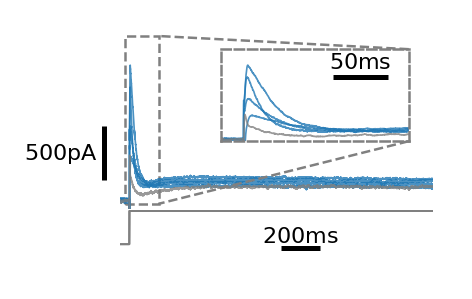

In [27]:
FIT_EXAMPLE_NO = 5
BG_TR_ALPHA = 0.8

tr_spec = gs.GridSpec(
    2,
    1,
    height_ratios=[1, 0.2],
    hspace=0,
    top=0.97,
    bottom=0.05,
    right=0.97,
    left=0.1,
)

plt.figure(figsize=(1.5, 1))

wc_ax = plt.subplot(tr_spec[0, :])
plt.plot(
    (IA_inactivation['traces'][IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']),
    IA_inactivation['traces'][IA_inactivation['peak_exists'], 0, :].T,
    '-',
    color=colors['ser'],
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.plot(
    (IA_inactivation['traces'][~IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']),
    IA_inactivation['traces'][~IA_inactivation['peak_exists'], 0, :].T,
    '-',
    color='gray',
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.xlim(-50, 1550)
plt.ylim(-100, 1600)
pltools.add_scalebar(
    y_units='pA', omit_x=True, anchor=(-0.05, 0.1), linewidth=sbarlw
)
sns.despine(ax=plt.gca(), trim=True)

wc_ins = inset_axes(wc_ax, '60%', '50%', loc='upper right', borderpad=1.2)
plt.plot(
    (IA_inactivation['traces'][IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']),
    IA_inactivation['traces'][IA_inactivation['peak_exists'], 0, :].T,
    '-',
    color=colors['ser'],
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.plot(
    (IA_inactivation['traces'][~IA_inactivation['peak_exists'], 2, :].T - peak_fit_params['stimulus_start_time']),
    IA_inactivation['traces'][~IA_inactivation['peak_exists'], 0, :].T,
    '-',
    color='gray',
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.xlim(-20, 150)
plt.ylim(-50, 1500)
pltools.add_scalebar(
    x_units='ms',
    omit_y=True,
    anchor=(0.95, 0.7),
    x_label_space=0.05,
    remove_frame=False,
    linewidth=sbarlw,
)
plt.xticks([])
plt.yticks([])
dashedBorder(wc_ins, lw=insetlw)
mark_inset(wc_ax, wc_ins, 1, 4, ls='--', color='gray', lw=insetlw)

plt.subplot(tr_spec[1, :])
plt.plot(
    (IA_inactivation['traces'][:, 2, :].T - peak_fit_params['stimulus_start_time']),
    IA_inactivation['traces'][:, 1, :].T,
    '-',
    color=colors['input'],
    lw=0.5,
    alpha=BG_TR_ALPHA,
)
plt.xlim(-50, 1550)
pltools.add_scalebar(
    x_units='ms',
    x_size=200,
    omit_y=True,
    anchor=(0.7, -0.05),
    x_label_space=0.05,
    linewidth=sbarlw,
)

plt.tight_layout()

if IMG_PATH is not None:
    savefig(os.path.join(IMG_PATH, 'ser_kinetics_trace_only_heated'))

plt.show()

In [28]:
del ctrl_recs

# Pharmacology

the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release
the default signal_group_mode will change from 'split-all' to 'group-by-same-units' in next release


Saving svg
Saving png
Done!


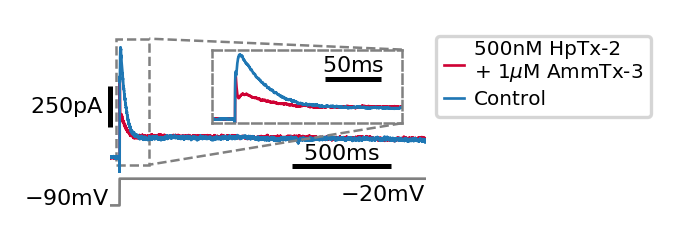

Saving svg
Saving png
Done!


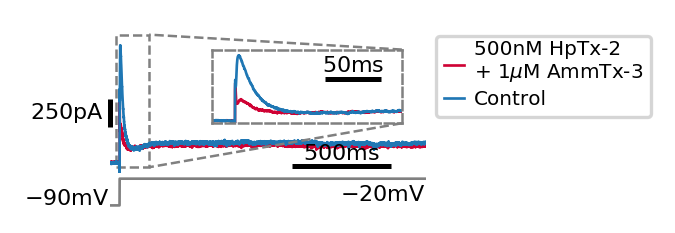

In [29]:
rec_index['blockers'] = (rec_index['heteropodatoxin2_nanomolar'] > 0) & (rec_index['ammtx3_micromolar'] > 0)
rec_index['baseline'] = (rec_index['heteropodatoxin2_nanomolar'] == 0) & (rec_index['ammtx3_micromolar'] == 0)
cells_with_blockers = set(rec_index.loc[rec_index['blockers'], 'cell_id'])
pharm_rec_names = rec_index.query(
    'cell_id in @cells_with_blockers and (blockers or baseline) and include'
).pivot('cell_id', 'baseline', 'filename')

pharm_recs = pharm_rec_names.copy()
for col_idx in pharm_recs.columns:
    pharm_recs[col_idx] = pharm_recs[col_idx].astype(object)

from itertools import product
l = ABFLoader()

for row_idx, col_idx in product(pharm_recs.index, pharm_recs.columns):
    pharm_recs.loc[row_idx, col_idx] = preprocess_recording(l.load([
        os.path.join(DATA_PATH, 'raw', '5HT', 'heated_gating', pharm_recs.loc[row_idx, col_idx])
    ])[0])
    pharm_recs.loc[row_idx, col_idx][VOLTAGE_CHANNEL, :, :] /= 20.  # Hack to deal with scaling of voltage channel

del product

spec = gs.GridSpec(2, 1, height_ratios=[1, 0.2])

for (_, row), ylims in zip(pharm_recs.iterrows(), ([-100, 800], [-100, 1200])):
    fig, axes = plt.subplots(
        2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 0.2], 'hspace': 0.05}, figsize=(1.7, 1)
    )
    
    axes[0].plot(
        row[False].time_supp - peak_fit_params['stimulus_start_time'], 
        row[False][CURRENT_CHANNEL, :, -1],
        color=colors['4AP'],
        label='500nM HpTx-2\n+ 1$\mu$M AmmTx-3'
    )
    axes[0].plot(
        row[True].time_supp - peak_fit_params['stimulus_start_time'], 
        row[True][CURRENT_CHANNEL, :, -1],
        color=colors['ser'],
        label='Control'
    )
    axes[0].set_xlim(-50, 1550)
    axes[0].set_ylim(ylims)
    pltools.add_scalebar(
        x_size=500,
        x_units='ms',
        omit_y=True,
        anchor=(0.95, 0.05),
        x_label_space=0.01,
        remove_frame=False,
        linewidth=sbarlw,
        ax=axes[0]
    )
    pltools.add_scalebar(
        y_size=250,
        y_units='pA',
        omit_x=True,
        anchor=(0., 0.25),
        remove_frame=True,
        linewidth=sbarlw,
        ax=axes[0]
    )
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    pharm_ins = inset_axes(axes[0], '60%', '50%', loc='upper right', borderpad=1.2)
    pharm_ins.plot(
        row[False].time_supp - peak_fit_params['stimulus_start_time'], 
        row[False][CURRENT_CHANNEL, :, -1],
        color=colors['4AP']
    )
    pharm_ins.plot(
        row[True].time_supp - peak_fit_params['stimulus_start_time'], 
        row[True][CURRENT_CHANNEL, :, -1],
        color=colors['ser']
    )
    pharm_ins.set_xlim(-20, 150)
    pharm_ins.set_ylim(-50, ylims[1] - 80)
    pltools.add_scalebar(
        x_size=50,
        x_units='ms',
        omit_y=True,
        anchor=(0.95, 0.6),
        x_label_space=0.05,
        remove_frame=False,
        linewidth=sbarlw,
        ax=pharm_ins
    )
    pharm_ins.set_xticks([])
    pharm_ins.set_yticks([])
    dashedBorder(pharm_ins, lw=insetlw)
    mark_inset(axes[0], pharm_ins, 1, 4, ls='--', color='gray', lw=insetlw)
    
    axes[1].plot(
        row[True].time_supp - peak_fit_params['stimulus_start_time'], 
        row[True][VOLTAGE_CHANNEL, :, -1],
        color=colors['input']
    )
    pltools.hide_border(ax=axes[1])
    axes[1].text(-50, -90, '$-$90mV', ha='right', size='small')
    axes[1].text(1550, -35, '$-$20mV', ha='right', va='top', size='small')
    
    savefig(os.path.join(IMG_PATH, 'ser_kv4_pharmacology_heated_{}'.format(row.name)))
    plt.show()